In [1]:
import misc.trs_refactor as trs
import numpy as np
import matplotlib_inline
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import zarr
import os
import zstd
import numcodecs
import json
from ttictoc import tic, toc

In [2]:
# Specify the path to your JSON file (adjust as necessary)
path = "."  # Folder where "Metadata 00012.json" is located
name = "Metadata"
number = 12
ext = "json"

# Instantiate the Metadata object
metadata_instance = trs.Metadata(path, name, number, ext)

# Print out some details
print(f"CCD (nx, ny): ({metadata_instance.md_ccd_nx}, {metadata_instance.md_ccd_ny})")
print(f"Pass Energy: {metadata_instance.md_pass_energy}")
print(f"Center Energy: {metadata_instance.md_center_energy}")
print(f"Rectangle Coordinates: Left {metadata_instance.roi_l}, Top {metadata_instance.roi_t}, Right {metadata_instance.roi_r}, Bottom {metadata_instance.roi_b}")

# Print the entire metadata
print(metadata_instance)

CCD (nx, ny): (1392, 1040)
Pass Energy: 200
Center Energy: 1954
Rectangle Coordinates: Left 148, Top 385, Right 1279, Bottom 654
{
    "F_Trigger": 19,
    "F_Un-Trigger": 81,
    "F_Dead": 143,
    "F_Reset": 150,
    "CCD_nx": 1392,
    "CCD_ny": 1040,
    "Pass Energy": 200,
    "Center Energy": 1954,
    "Offset Energy": -0.837,
    "Lens Mode": "X6-26Mar2022-test",
    "Rectangle": {
        "Left": 148,
        "Top": 385,
        "Right": 1279,
        "Bottom": 654,
        "Rotation": 0
    },
    "Notes": "",
    "dt": 0.0820741786426572,
    "Photon Energy": 3999.99965566672,
    "Binding Energy": 90,
    "File Ver": "1.0.0",
    "Stream": "Full Frame (FF)"
}


In [3]:
""" Read a frame from a Frame Stream
MAKE sure you don't put a space after "Frame Stream" even so the filename is "Frame Stream " followed by the number
The number also to be 12 NOT 00012 like the filename """
    
frame_stream = trs.FrameStream(path=".", name="Frame Stream", number=12, ext="bin")
ccd_image, normalization = frame_stream.__frame_data__(frame_i=0)
print(ccd_image, normalization)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 4.894080810008295


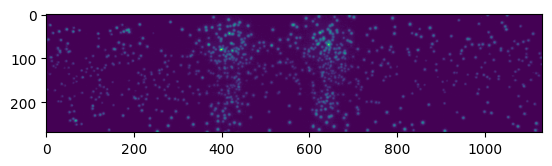

In [4]:
plt.imshow(ccd_image[385:654,148:1279])

In [5]:
""" Read the averaged spectrum from an ESpec Stream averaged over 
 "Rectangle": {
        "Left": 148,
        "Top": 385,
        "Right": 1279,
        "Bottom": 654,
        "Rotation": 0
    },
"""
espec_stream = trs.ESpecStream(path=".", name="ESpectrum Stream", number=12, ext="bin")


In [6]:
""" Extract the scan for frame_i = 0"""
espec_data, normalization = espec_stream.__espec_data__(frame_i=0)
print(espec_data, normalization)


[81 53 45 ... 51 47 48] 4.894080810008295


In [7]:
espec_data.shape[0]

1131

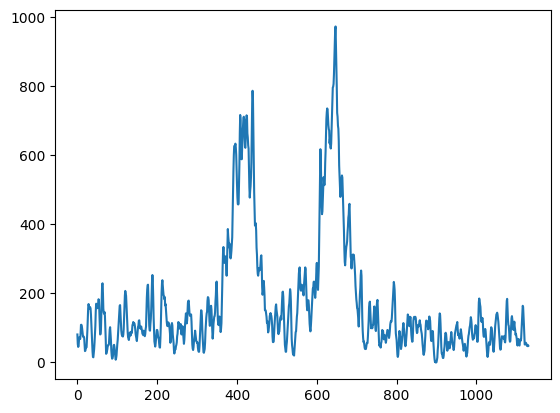

In [8]:
plt.plot(espec_data)

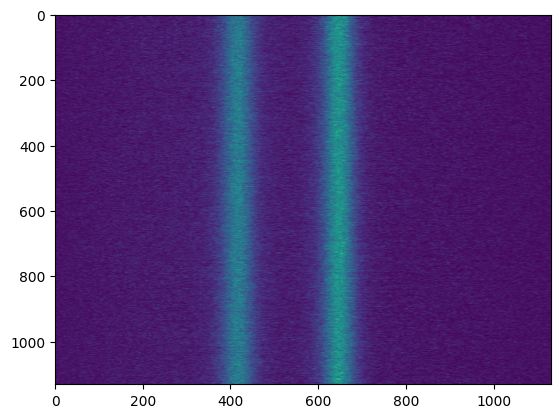

In [9]:

# Assuming espec_stream is your ESpecStream object initialized correctly
# And assuming total_line_scans represents the total number of frames

line_scans = []
for frame_i in range(int(espec_data.shape[0])):  # Ensure it's an integer
    espec_data, normalization = espec_stream.__espec_data__(frame_i)
    line_scans.append(espec_data)

# Convert the list of line scans into a 2D NumPy array
image_data = np.vstack(line_scans)  # Stack vertically

# If you need to transpose the image (depending on the orientation you need)
# image_data = image_data.T

# Proceed with visualization or saving as previously described
plt.imshow(image_data, aspect="auto")

In [10]:
# # VERY slow verion

# # Assuming espec_stream.num_frames is corrected to be an integer
# espec_data_list = []
# for frame_i in range(int(espec_stream.num_frames)):
#     frame_data, _ = espec_stream.__espec_data__(frame_i)
#     espec_data_list.append(frame_data)

# # Convert the list of arrays to a single NumPy array
# espec_data = np.array(espec_data_list)

# print('Number of frame: ' + str(int(frame_stream.num_frames)))
# # Example dimensions, replace these with actual dimensions
# n_frames = int(frame_stream.num_frames)  # Total number of frames
# frame_height = frame_stream.n_y  # Height of a frame
# frame_width = frame_stream.n_x  # Width of a frame

# # Preallocate the array with zeros or another placeholder value
# frame_data = np.zeros((frame_height, frame_width, n_frames), dtype=np.float32)  # Adjust dtype as needed
# dummy = 1 
# tic()
# # Fill in the data for each frame
# for frame_i in range(300): #range(n_frames): JUST writing 100 frame instead of all frames
#     dummy += 1
#     if dummy % 100 == 0:
#         print(dummy)
#     frame_image, _ = frame_stream.__frame_data__(frame_i)
#     frame_data[:, :, frame_i] = frame_image
# print(toc())
# tic()
# print(frame_data.shape)
# #Incase we have memory issues 
# # frame_data = np.memmap('frame_data.dat', dtype=np.float32, mode='w+', shape=(frame_height, frame_width, n_frames))

# # for frame_i in range(n_frames):
# #     frame_image, _ = frame_stream.__frame_data__(frame_i)
# #     frame_data[:, :, frame_i] = frame_image

# # or  but this is even slower# Force num_frames to be an integer when using it
# # num_frames_int = int(espec_stream.num_frames)
# # for frame_i in range(num_frames_int):
# #     frame_data, _ = espec_stream.__espec_data__(frame_i)
# #     espec_data_list.append(frame_data)



# # Create a Zarr group to store your datasets
# root_group = zarr.open("./test_slow.zarr", mode="w")

# with open('./Metadata 00012.json', 'r') as f:
#      metadata = json.load(f)

# # Store the metadata as an attribute of the root group
# root_group.attrs['metadata'] = metadata

# # Specify a compressor, for example Zstandard with compression level 3
# compressor = numcodecs.Zstd(level=3)
# print(toc())
# tic()
# # Then use this compressor when creating datasets
# root_group.create_dataset("espec_data", data=espec_data, chunks=True, compressor=compressor)
# root_group.create_dataset("frame_data", data=frame_data, chunks=True, compressor=compressor)
# print(toc())

In [12]:
''' THis is a  faster version'''
from concurrent.futures import ThreadPoolExecutor
import numpy as np
tic()
# Example frame dimensions and number of frames
n_frames = 400  # Total number of frames
frame_height = frame_stream.n_y  # Height of a frame, for example 1080
frame_width = frame_stream.n_x  # Width of a frame, for example 1920

# Function to retrieve frame data; this needs to be compatible with how your frame_stream object works
def get_frame_data(frame_i):
    return frame_stream.__frame_data__(frame_i)[0]

# Use ThreadPoolExecutor to parallelize frame data retrieval
with ThreadPoolExecutor() as executor:
    frame_data_list = list(executor.map(get_frame_data, range(n_frames)))

# Assuming all frames have the same shape, you can stack them into a single NumPy array
frame_data = np.stack(frame_data_list, axis=-1)

print(frame_data.shape)
print(toc())
tic()

# Create a Zarr group to store your datasets
root_group = zarr.open("./test_fast.zarr", mode="w")

with open('./Metadata 00012.json', 'r') as f:
     metadata = json.load(f)

# Store the metadata as an attribute of the root group 
root_group.attrs['metadata'] = metadata

# Specify a compressor, for example Zstandard with compression level 3
compressor = numcodecs.Zstd(level=0)
print(toc())
tic()
# Then use this compressor when creating datasets
root_group.create_dataset("espec_data", data=espec_data, chunks=True, compressor=compressor)
root_group.create_dataset("frame_data", data=frame_data, chunks=True, compressor=compressor)
print(toc())

(1040, 1392, 400)
27.277216125046834
0.002911041956394911
2.7824180830502883


In [11]:
import zarr
import numcodecs
from frame_utils import get_frame_data


# Set the total number of frames and other parameters
n_frames = 400  # Total number of frames
path = "."  # Example path
name = "Frame Stream"  # Example name
number = 12  # Example number
ext = "bin"  # File extension

# Define the dimensions of a frame
frame_height = frame_stream.n_y  # Height of a frame,
frame_width = frame_stream.n_x  # Width of a frame, 

# Initialize the Zarr dataset
root_group = zarr.open("./test_faster.zarr", mode="w")
compressor = numcodecs.Zstd(level=3)  # Compressor configuration

with open('./Metadata 00012.json', 'r') as f:
     metadata = json.load(f)

# Store the metadata as an attribute of the root group 
root_group.attrs['metadata'] = metadata

root_group.create_dataset("espec_data", data=espec_data, chunks=True, compressor=compressor)

chunks = (1, frame_height, frame_width)  # Define chunks

# Create the dataset within the Zarr file
frame_data_zarr = root_group.create_dataset(
    "frame_data",
    shape=(n_frames, frame_height, frame_width),
    chunks=chunks,
    dtype=np.float32,
    compressor=compressor
)

# Sequentially retrieve and store frame data
for frame_i in range(n_frames):
    # Retrieve frame data using the defined function
    frame_data = get_frame_data(frame_i, path, name, number, ext)
    
    # Write the frame data directly into the Zarr dataset
    frame_data_zarr[frame_i, :, :] = frame_data

print("Data processing completed.")

# Open the Zarr file (or directory)
root_group = zarr.open('./test_faster.zarr', mode='r')
# List all items (datasets and groups) at the root level
print(list(root_group.keys()))

# List all attributes of the root group
print(dict(root_group.attrs))
for name in root_group.keys():
    item = root_group[name]
    if isinstance(item, zarr.core.Array):
        print(f"Dataset '{name}' with shape {item.shape} and dtype {item.dtype}")
    elif isinstance(item, zarr.hierarchy.Group):
        print(f"Group '{name}' containing {list(item.keys())}")


KeyboardInterrupt: 

In [12]:
""" parallel but not faster"""
import zarr
import numcodecs
from frame_utils import get_frame_data
from concurrent.futures import ThreadPoolExecutor
n_frames = 400  # Total number of frames
path = "."  # Example path
name = "Frame Stream"  # Example name
number = 12  # Example number
ext = "bin"  # File extension

# Define the dimensions of a frame
frame_height = frame_stream.n_y  # Height of a frame,
frame_width = frame_stream.n_x  # Width of a frame, 
# Configuration and dataset initialization as before

# Define the structure of your Zarr dataset
root_group = zarr.open("./test_faster.zarr", mode="w")
compressor = numcodecs.Zstd(level=3)
chunks = (1, frame_height, frame_width)

frame_data_zarr = root_group.create_dataset(
    "frame_data", 
    shape=(n_frames, frame_height, frame_width), 
    chunks=chunks, 
    dtype=np.float32, 
    compressor=compressor
)

# Function to be executed in parallel
def process_frame(frame_i):
    frame_data = get_frame_data(frame_i, path, name, number, ext)
    frame_data_zarr[frame_i, :, :] = frame_data

# Using ThreadPoolExecutor to retrieve and store frame data in parallel
with ThreadPoolExecutor(max_workers=19) as executor:  # Adjust `max_workers` as needed
    # Submit all tasks to the executor
    futures = [executor.submit(process_frame, frame_i) for frame_i in range(n_frames)]
    
    # Wait for all futures to complete (optional, if you need to process results further)
    for future in futures:
        future.result()  # This will raise exceptions if any occurred during execution

print("Parallel data processing completed.")


Parallel data processing completed.
